# Finding The Best Location to Build Medical Center in Jakarta


This project aims to find the best districts to build new medical centres in Jakarta by considering the number of existing medical centres available within those districts and the total population. This project may help Jakarta’s Government to make better decisions to improve Jakarta’s health system by prioritizing districts where medical centres are lacked. This project may also beneficial for investors who are planning to build new medical centres in Jakarta.

## Preparing The Data

### Getting The List of Jakarta's Districts

The data are taken from kodeposresmi.com. The data contain all districs and subdistricts in Jakarta along with their postcodes

In [1]:
# Importing required packages
import pandas as pd
import numpy as np

# Using pandas to read the data from the url
jkt_dt = []
for i in range(1, 28):
    url = 'https://kodeposresmi.com/provinsi/dki-jakarta/page/'+str(i)
    jkt_dt.append(pd.read_html(url)[0])

jkt_districts = pd.concat(jkt_dt)

In [2]:
jkt_districts.head()

,Provinsi,Kabupaten/Kota,Kecamatan,Kelurahan,Kode Pos
0,DKI Jakarta,Kabupaten Kepulauan Seribu,Kepulauan Seribu Selatan,Pulau Pari,14520
1,DKI Jakarta,Kabupaten Kepulauan Seribu,Kepulauan Seribu Selatan,Pulau Tidung,14520
2,DKI Jakarta,Kabupaten Kepulauan Seribu,Kepulauan Seribu Selatan,Pulau Untung Jawa,14510
3,DKI Jakarta,Kabupaten Kepulauan Seribu,Kepulauan Seribu Utara,Pulau Harapan,14540
4,DKI Jakarta,Kabupaten Kepulauan Seribu,Kepulauan Seribu Utara,Pulau Kelapa,14540


Let's clean the data. Only Municipalities and Districts data are going to be used, so we need to delete the other columns. We also need to remove duplicate and empty rows then reset the index.

In [3]:
del jkt_districts['Provinsi']
del jkt_districts['Kelurahan']
del jkt_districts['Kode Pos']
jkt_districts.drop_duplicates(inplace=True)
jkt_districts.dropna(inplace=True)
jkt_districts.reset_index(drop=True, inplace=True)

The column names are still in Indonesian. To reach global investors let's change them to English!

In [4]:
jkt_districts.rename(columns={'Kabupaten/Kota': 'Municipalities', 'Kecamatan': 'Districts'},inplace=True)

Done! We have finished cleaning districts data

In [5]:
jkt_districts.head()

,Municipalities,Districts
0,Kabupaten Kepulauan Seribu,Kepulauan Seribu Selatan
1,Kabupaten Kepulauan Seribu,Kepulauan Seribu Utara
2,Kota Jakarta Barat,Cengkareng
3,Kota Jakarta Barat,Grogol Petamburan
4,Kota Jakarta Barat,Kalideres


### Joining The District Data With Coordinate Data

We need coordinates data for each districts to create the map and search for existing medical centers using Foursquare API. We also need the total population data of each districts for better decision making. Those data need to be joined with the previous district data.

The coordinates data are taken from Google while the population data are taken from Statistics Indonesia.

In [6]:
# Load the data
ll_df = pd.read_csv('districts.csv')

# Join the latitude and longitude data with the districts data
jkt_districts = pd.merge(jkt_districts, 
                  ll_df,
                  left_on='Districts',
                  right_on='Kecamatan',
                  how='left')

To simplify the dataframe we need to remove unused columns.

In [7]:
del jkt_districts['Kabupaten/Kota']
del jkt_districts['Kecamatan']

Here are the final initial data for our analysis :

In [8]:
jkt_districts.head()

,Municipalities,Districts,Latitude,Longitude,Population
0,Kabupaten Kepulauan Seribu,Kepulauan Seribu Selatan,-5.926341,106.633551,10101
1,Kabupaten Kepulauan Seribu,Kepulauan Seribu Utara,-5.478190,106.548259,14053
2,Kota Jakarta Barat,Cengkareng,-6.148665,106.735258,601156
3,Kota Jakarta Barat,Grogol Petamburan,-6.162275,106.788342,241564
4,Kota Jakarta Barat,Kalideres,-6.134294,106.705773,471436


## Plotting The District Data

Let's explore the Jakarta's districts data by plotting the coordinates data into the map.

First we need to get the coordinates of Jakarta

In [9]:
# Importing the package
from geopy.geocoders import Nominatim

address = 'Jakarta,Indonesia'
geolocator = Nominatim(user_agent="jakarta_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

print('The geograpical coordinates of Jakarta are {}, {}.'.format(latitude, longitude))

The geograpical coordinates of Jakarta are -6.1753942, 106.827183.


Now let's create the map using latitute and longitue values. We're going to add <b>bubbles</b> to the map which represent the districts and their population size.

In [10]:
# Importing the package
import folium

# Creating the initial map
map_jakarta = folium.Map(location=[latitude,longitude], zoom_start=11)

# Adding bubble markers to the map
for lat, lng, dist, mun, pop in zip(jkt_districts['Latitude'], jkt_districts['Longitude'], jkt_districts['Districts'], jkt_districts['Municipalities'], jkt_districts['Population']):
    label = '{}, {}'.format(dist, mun)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=pop/30000,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.5,
        parse_html=False).add_to(map_jakarta)  
    
map_jakarta

From the map above we can see that Cengkareng, Cakung, and Kalideres have the biggest population.

## Getting The Medical Centers Data

We need to gather existing medical centers data in each districts in order to choose the potential location for a new medical center.

The data will be taken from Foursquare using their API.

### Building A Function to Get The Data

We are going to search for venues with specific category which is Medical Center (Category ID : 4bf58dd8d48988d104941735). We need to create a special function (getMedicalCenters) for that. 

In [12]:
import requests

def getMedicalCenters(names, latitudes, longitudes, radius=500, LIMIT=100):

    mc_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL        
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId=4bf58dd8d48988d104941735'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius,
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        mc_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['categories'][0]['name'],
            v['venue']['location']['lat'], 
            v['venue']['location']['lng']) for v in results])

    nearby_mc = pd.DataFrame([item for m_list in mc_list for item in m_list])
    nearby_mc.columns = ['District', 
                  'District Latitude', 
                  'District Longitude', 
                  'Medical Center Name', 
                  'Category',
                  'MC Latitude', 
                  'MC Longitude']
    
    return(nearby_mc)

Let's call the function to get our data

In [13]:
jkt_medical_centers= getMedicalCenters(names=jkt_districts['Districts'],
                                   latitudes=jkt_districts['Latitude'],
                                   longitudes=jkt_districts['Longitude']
                                  )

Kepulauan Seribu Selatan
Kepulauan Seribu Utara
Cengkareng
Grogol Petamburan
Kalideres
Kebon Jeruk
Kembangan
Palmerah
Taman Sari
Tambora
Cempaka Putih
Gambir
Johar Baru
Kemayoran
Menteng
Sawah Besar
Senen
Tanah Abang
Cilandak
Jagakarsa
Kebayoran Baru
Kebayoran Lama
Mampang Prapatan
Pancoran
Pasar Minggu
Pesanggrahan
Setia Budi
Tebet
Cakung
Cipayung
Ciracas
Duren Sawit
Jatinegara
Kramat Jati
Makasar
Matraman
Pasar Rebo
Pulo Gadung
Cilincing
Kelapa Gading
Koja
Pademangan
Penjaringan
Tanjung Priok


Here are our medical centers data :

In [14]:
jkt_medical_centers.head()

,District,District Latitude,District Longitude,Medical Center Name,Category,MC Latitude,MC Longitude
0,Cengkareng,-6.148665,106.735258,Klinik Dr Hamid Handoyo Suryo,Medical Center,-6.146981,106.735607
1,Cengkareng,-6.148665,106.735258,BKM St.Carolus Cengkareng,Doctor's Office,-6.147905,106.736217
2,Grogol Petamburan,-6.162275,106.788342,Rumah sakit Hermina,Medical Center,-6.164363,106.789669
3,Grogol Petamburan,-6.162275,106.788342,Klinik Kecantikan Dr. Mulyana,Doctor's Office,-6.161576,106.789157
4,Grogol Petamburan,-6.162275,106.788342,Puspa Skin & Slimming Center,Medical Center,-6.159850,106.791722


## Clustering The Districts

The purpose of this step is to understand our data better. Using clustered districts data we can find similar districts and understand how those clusters differ from the others. It will help us to find potential district cluster which fall into our criteria.

### Preparing the Data for Clustering

First we need to count how many medical centers each district has for each category.

In [15]:
jkt_mc_by_cat = pd.DataFrame({'Count' : jkt_medical_centers.groupby(['District','Category']).size()}).reset_index()

In [16]:
jkt_mc_by_cat.head()

,District,Category,Count
0,Cempaka Putih,Doctor's Office,1
1,Cempaka Putih,Medical Center,3
2,Cengkareng,Doctor's Office,1
3,Cengkareng,Medical Center,1
4,Cilandak,Dentist's Office,1


Let's transform the data above into pivot table to help our clustering model perform better

In [17]:
jkt_mc_pv = pd.pivot_table(jkt_mc_by_cat, values="Count", index="District", columns="Category",
                    aggfunc = np.sum).fillna(0)

In [18]:
jkt_mc_pv.head()

Category,Acupuncturist,Dentist's Office,Doctor's Office,Emergency Room,Hospital,Medical Center,Medical Lab,Veterinarian
District,,,,,,,,
Cempaka Putih,0.0,0.0,1.0,0.0,0.0,3.0,0.0,0.0
Cengkareng,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
Cilandak,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
Duren Sawit,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
Gambir,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0


Merge the pivot table with previous data

In [22]:
jkt_districts_mc = pd.merge(jkt_districts, 
                  jkt_mc_pv,
                  left_on='Districts',
                  right_on='District',
                  how='left').fillna(0)

In [23]:
jkt_districts_mc.head()

,Municipalities,Districts,Latitude,Longitude,Population,Acupuncturist,Dentist's Office,Doctor's Office,Emergency Room,Hospital,Medical Center,Medical Lab,Veterinarian
0,Kabupaten Kepulauan Seribu,Kepulauan Seribu Selatan,-5.926341,106.633551,10101,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Kabupaten Kepulauan Seribu,Kepulauan Seribu Utara,-5.478190,106.548259,14053,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Kota Jakarta Barat,Cengkareng,-6.148665,106.735258,601156,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,Kota Jakarta Barat,Grogol Petamburan,-6.162275,106.788342,241564,0.0,1.0,2.0,0.0,8.0,2.0,1.0,0.0
4,Kota Jakarta Barat,Kalideres,-6.134294,106.705773,471436,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


We'll just focus on medical centers for general purpose so let's delete some catagories

In [24]:
del jkt_districts_mc["Acupuncturist"]
del jkt_districts_mc["Dentist's Office"]
del jkt_districts_mc["Emergency Room"]
del jkt_districts_mc["Medical Lab"]
del jkt_districts_mc["Veterinarian"]

In [25]:
jkt_districts_mc.head()

,Municipalities,Districts,Latitude,Longitude,Population,Doctor's Office,Hospital,Medical Center
0,Kabupaten Kepulauan Seribu,Kepulauan Seribu Selatan,-5.926341,106.633551,10101,0.0,0.0,0.0
1,Kabupaten Kepulauan Seribu,Kepulauan Seribu Utara,-5.478190,106.548259,14053,0.0,0.0,0.0
2,Kota Jakarta Barat,Cengkareng,-6.148665,106.735258,601156,1.0,0.0,1.0
3,Kota Jakarta Barat,Grogol Petamburan,-6.162275,106.788342,241564,2.0,8.0,2.0
4,Kota Jakarta Barat,Kalideres,-6.134294,106.705773,471436,1.0,0.0,1.0


Let's create a new feature called "MC per Population". This new feature represents of the number of medical center per population for each district. This new feature will help us to decide potential districts (districts with low MC per Population)

In [26]:
jkt_districts_mc["MC per Population"] = jkt_districts_mc.iloc[:,5:9].sum(axis=1)/jkt_districts_mc["Population"]

In [27]:
jkt_mc_clust_dt = jkt_districts_mc[:]
jkt_mc_clust_dt.head()

,Municipalities,Districts,Latitude,Longitude,Population,Doctor's Office,Hospital,Medical Center,MC per Population
0,Kabupaten Kepulauan Seribu,Kepulauan Seribu Selatan,-5.926341,106.633551,10101,0.0,0.0,0.0,0.000000
1,Kabupaten Kepulauan Seribu,Kepulauan Seribu Utara,-5.478190,106.548259,14053,0.0,0.0,0.0,0.000000
2,Kota Jakarta Barat,Cengkareng,-6.148665,106.735258,601156,1.0,0.0,1.0,0.000003
3,Kota Jakarta Barat,Grogol Petamburan,-6.162275,106.788342,241564,2.0,8.0,2.0,0.000050
4,Kota Jakarta Barat,Kalideres,-6.134294,106.705773,471436,1.0,0.0,1.0,0.000004


We need to delete some variables that won't help much for our model

In [28]:
del jkt_mc_clust_dt["Latitude"]
del jkt_mc_clust_dt["Longitude"]
del jkt_mc_clust_dt["Municipalities"]
del jkt_mc_clust_dt["Population"]

Here's the final data

In [29]:
jkt_mc_clust_dt.head()

,Districts,Doctor's Office,Hospital,Medical Center,MC per Population
0,Kepulauan Seribu Selatan,0.0,0.0,0.0,0.000000
1,Kepulauan Seribu Utara,0.0,0.0,0.0,0.000000
2,Cengkareng,1.0,0.0,1.0,0.000003
3,Grogol Petamburan,2.0,8.0,2.0,0.000050
4,Kalideres,1.0,0.0,1.0,0.000004


### Using K-Means to Cluster the Districts

Our variables need to be in the same scale in order to perform better. Let's transform the variables

In [30]:
from sklearn.preprocessing import StandardScaler
jkt_mc_clust_dt = StandardScaler().fit_transform(jkt_mc_clust_dt.iloc[:,1:])
jkt_mc_clust_dt

array([[-6.45104838e-01, -5.51065550e-01, -8.57536563e-01,
        -6.39955183e-01],
       [-6.45104838e-01, -5.51065550e-01, -8.57536563e-01,
        -6.39955183e-01],
       [ 1.50024381e-02, -5.51065550e-01, -3.02659963e-01,
        -5.54795797e-01],
       [ 6.75109714e-01,  2.85200592e+00,  2.52216636e-01,
         6.31610344e-01],
       [ 1.50024381e-02, -5.51065550e-01, -3.02659963e-01,
        -5.31363400e-01],
       [ 1.50024381e-02, -1.25681617e-01, -3.02659963e-01,
        -4.39544100e-01],
       [ 1.50024381e-02, -5.51065550e-01,  2.52216636e-01,
        -4.10120803e-01],
       [-6.45104838e-01, -5.51065550e-01, -8.57536563e-01,
        -6.39955183e-01],
       [ 1.99532427e+00, -5.51065550e-01,  2.52216636e-01,
         7.53055623e-01],
       [ 1.50024381e-02, -1.25681617e-01,  2.52216636e-01,
        -2.16669495e-01],
       [ 1.50024381e-02, -5.51065550e-01,  8.07093236e-01,
         5.55232598e-01],
       [ 1.50024381e-02, -5.51065550e-01, -3.02659963e-01,
      

In [31]:
jkt_mc_clust_dt=pd.DataFrame(jkt_mc_clust_dt)

How many clusters will give us the optimal result? Let's find out by using The Elbow Method

In [32]:
from sklearn.cluster import KMeans 
from sklearn import metrics 
from scipy.spatial.distance import cdist 
import numpy as np 
import matplotlib.pyplot as plt

distortions = [] 
inertias = [] 
mapping1 = {} 
mapping2 = {} 
K = range(1,10) 
  
for k in K: 
    #Building and fitting the model 
    kmeanModel = KMeans(n_clusters=k).fit(jkt_mc_clust_dt) 
    kmeanModel.fit(jkt_mc_clust_dt)     
      
    distortions.append(sum(np.min(cdist(jkt_mc_clust_dt, kmeanModel.cluster_centers_, 
                      'euclidean'),axis=1)) / jkt_mc_clust_dt.shape[0]) 
    inertias.append(kmeanModel.inertia_) 
  
    mapping1[k] = sum(np.min(cdist(jkt_mc_clust_dt, kmeanModel.cluster_centers_, 
                 'euclidean'),axis=1)) / jkt_mc_clust_dt.shape[0] 
    mapping2[k] = kmeanModel.inertia_ 

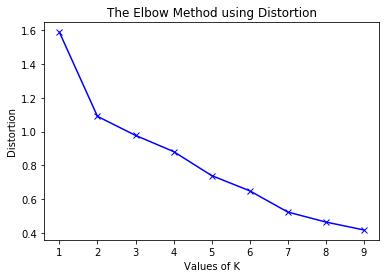

In [33]:
plt.plot(K, distortions, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Distortion') 
plt.title('The Elbow Method using Distortion') 
plt.show() 

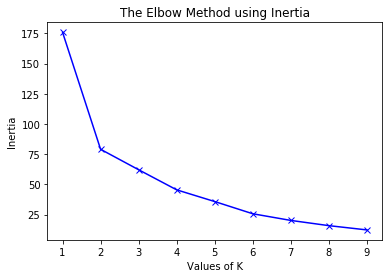

In [34]:
plt.plot(K, inertias, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Inertia') 
plt.title('The Elbow Method using Inertia') 
plt.show() 

Based on the method above we can see that 2 clusters will give us the best result. Let's apply it to our model.

In [35]:
from sklearn.cluster import KMeans

# set number of clusters
kclusters = 2

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(jkt_mc_clust_dt)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([1, 1, 1, 0, 1, 1, 1, 1, 0, 1])

Here's the label for each district :

In [36]:
kmeans.labels_

array([1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1])

In [37]:
jkt_districts_mc["Cluster"] = kmeans.labels_

In [38]:
jkt_districts_mc.head()

,Municipalities,Districts,Latitude,Longitude,Population,Doctor's Office,Hospital,Medical Center,MC per Population,Cluster
0,Kabupaten Kepulauan Seribu,Kepulauan Seribu Selatan,-5.926341,106.633551,10101,0.0,0.0,0.0,0.000000,1
1,Kabupaten Kepulauan Seribu,Kepulauan Seribu Utara,-5.478190,106.548259,14053,0.0,0.0,0.0,0.000000,1
2,Kota Jakarta Barat,Cengkareng,-6.148665,106.735258,601156,1.0,0.0,1.0,0.000003,1
3,Kota Jakarta Barat,Grogol Petamburan,-6.162275,106.788342,241564,2.0,8.0,2.0,0.000050,0
4,Kota Jakarta Barat,Kalideres,-6.134294,106.705773,471436,1.0,0.0,1.0,0.000004,1


Which cluster we are going to choose? Let's find some insights on how these clusters differ from each other

In [39]:
jkt_districts_mc[jkt_districts_mc["Cluster"]==0].mean(axis=0)

Latitude                 -6.185920
Longitude               106.834692
Population           141712.250000
Doctor's Office           3.500000
Hospital                  4.000000
Medical Center            4.500000
MC per Population         0.000094
Cluster                   0.000000
dtype: float64

In [40]:
jkt_districts_mc[jkt_districts_mc["Cluster"]==1].mean(axis=0)

Latitude                 -6.184583
Longitude               106.824677
Population           261777.000000
Doctor's Office           0.416667
Hospital                  0.694444
Medical Center            0.888889
MC per Population         0.000010
Cluster                   1.000000
dtype: float64

From the summary above we can conclude that districts on cluster 0 generally have more medical centers and MC per population than districts on cluster 1. We're going to select district for our new medical center from cluster 1.

In [47]:
selected_districts = jkt_districts_mc[jkt_districts_mc["Cluster"]==1]

In [48]:
selected_districts

,Municipalities,Districts,Latitude,Longitude,Population,Doctor's Office,Hospital,Medical Center,MC per Population,Cluster
0,Kabupaten Kepulauan Seribu,Kepulauan Seribu Selatan,-5.926341,106.633551,10101,0.0,0.0,0.0,0.000000,1
1,Kabupaten Kepulauan Seribu,Kepulauan Seribu Utara,-5.478190,106.548259,14053,0.0,0.0,0.0,0.000000,1
2,Kota Jakarta Barat,Cengkareng,-6.148665,106.735258,601156,1.0,0.0,1.0,0.000003,1
4,Kota Jakarta Barat,Kalideres,-6.134294,106.705773,471436,1.0,0.0,1.0,0.000004,1
5,Kota Jakarta Barat,Kebon Jeruk,-6.183459,106.764748,383168,1.0,1.0,1.0,0.000008,1
6,Kota Jakarta Barat,Kembangan,-6.191233,106.742319,334115,1.0,0.0,2.0,0.000009,1
7,Kota Jakarta Barat,Palmerah,-6.201802,106.789816,206353,0.0,0.0,0.0,0.000000,1
9,Kota Jakarta Barat,Tambora,-6.149040,106.803089,241889,1.0,1.0,2.0,0.000017,1
10,Kota Jakarta Pusat,Cempaka Putih,-6.182671,106.867990,85667,1.0,0.0,3.0,0.000047,1
11,Kota Jakarta Pusat,Gambir,-6.175392,106.827153,78534,1.0,0.0,1.0,0.000025,1


Here's the list of medical centers of districts from cluster 1

In [49]:
selected_districts_mc = jkt_medical_centers.loc[jkt_medical_centers['District'].isin(selected_districts["Districts"])]
selected_districts_mc = selected_districts_mc[selected_districts_mc['Category'].isin(("Medical Center","Doctor's Office","Hospital","Office"))]
selected_districts_mc

,District,District Latitude,District Longitude,Medical Center Name,Category,MC Latitude,MC Longitude
0,Cengkareng,-6.148665,106.735258,Klinik Dr Hamid Handoyo Suryo,Medical Center,-6.146981,106.735607
1,Cengkareng,-6.148665,106.735258,BKM St.Carolus Cengkareng,Doctor's Office,-6.147905,106.736217
16,Kalideres,-6.134294,106.705773,Klinik kecantikan KUSUMA,Medical Center,-6.137243,106.703104
17,Kalideres,-6.134294,106.705773,dr. Justus Kardiman,Doctor's Office,-6.130736,106.704590
18,Kebon Jeruk,-6.183459,106.764748,Jakarta Eye Center (Kb. Jeruk),Medical Center,-6.183414,106.767901
19,Kebon Jeruk,-6.183459,106.764748,Dr. Yuwono Prananto,Doctor's Office,-6.182446,106.764950
20,Kebon Jeruk,-6.183459,106.764748,Rumah Sakit Puri Mandiri Kedoya,Hospital,-6.184893,106.761508
21,Kembangan,-6.191233,106.742319,Chrysallis Pediatric Development Facility,Medical Center,-6.192470,106.745491
22,Kembangan,-6.191233,106.742319,Erha Apothecary Lippo Mall Puri,Medical Center,-6.189002,106.738786
23,Kembangan,-6.191233,106.742319,Dokter Mata (Dr. Kelvin),Doctor's Office,-6.191900,106.745209


Let's plot the existing medical center

In [50]:
from folium import plugins

map_jakarta = folium.Map(location=[latitude,longitude], zoom_start=11)

# add markers to map
for lat, lng, name, dist in zip(jkt_medical_centers['MC Latitude'], jkt_medical_centers['MC Longitude'], jkt_medical_centers['Medical Center Name'],jkt_medical_centers['District']):
    label = '{}, {}'.format(name,dist)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_jakarta)  

    
lt_ln = jkt_medical_centers[["MC Latitude", "MC Longitude"]].as_matrix().tolist()
map_jakarta.add_child(plugins.HeatMap(lt_ln))

# add markers to map
for lat, lng, dist in zip(selected_districts['Latitude'], selected_districts['Longitude'],selected_districts['Districts']):
    label = '{}'.format(dist)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=30,
        popup=label,
        color='red',
        fill=True,
        fill_color='#F08080',
        fill_opacity=0.2,
        parse_html=False).add_to(map_jakarta)


map_jakarta

C:\Users\Baiq Nurul Haqiqi\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Based on the map above some of potential districts are : Kepulauan Seribu Selatan, Kepulauan Seribu Utara, Koja, Cilincing, Cakung, Ciracas and Cipayung.

We can use "MC per Population" data for our final decision. Let's find out which districts have the lowest MC per Population.

In [51]:
selected_districts[selected_districts["MC per Population"]==selected_districts["MC per Population"].min()]

,Municipalities,Districts,Latitude,Longitude,Population,Doctor's Office,Hospital,Medical Center,MC per Population,Cluster
0,Kabupaten Kepulauan Seribu,Kepulauan Seribu Selatan,-5.926341,106.633551,10101,0.0,0.0,0.0,0.0,1
1,Kabupaten Kepulauan Seribu,Kepulauan Seribu Utara,-5.478190,106.548259,14053,0.0,0.0,0.0,0.0,1
7,Kota Jakarta Barat,Palmerah,-6.201802,106.789816,206353,0.0,0.0,0.0,0.0,1
13,Kota Jakarta Pusat,Kemayoran,-6.160372,106.847338,229175,0.0,0.0,0.0,0.0,1
21,Kota Jakarta Selatan,Kebayoran Lama,-6.244392,106.776544,309500,0.0,0.0,0.0,0.0,1
28,Kota Jakarta Timur,Cakung,-6.182629,106.947666,537756,0.0,0.0,0.0,0.0,1
29,Kota Jakarta Timur,Cipayung,-6.327251,106.900447,282360,0.0,0.0,0.0,0.0,1
30,Kota Jakarta Timur,Ciracas,-6.323116,106.870940,300345,0.0,0.0,0.0,0.0,1
34,Kota Jakarta Timur,Makasar,-6.271194,106.894546,204595,0.0,0.0,0.0,0.0,1
36,Kota Jakarta Timur,Pasar Rebo,-6.326164,106.856188,221158,0.0,0.0,0.0,0.0,1


We can conclude that Kepulauan Seribu Selatan dan Kepulauan Seribu Utara are the perfect location to build a new medical center because it is located the furthest from existing medical centers. However if the investor prefer to build a new medical center in the mainland then Cakung can be a perfect choice since it has more population than the rest.